<h2 style="font-family:camtasia;
          font-size:320%;
          font-weight: bold;
          color: #029db9;
          text-shadow: 2px 2px 2px rgba(0, 0, 0, 0.3);
          text-align:center;
          margin: 0 auto;
          padding:10px; ">
        Trash Type Classification using CNN
    </h2>

<a id="import"></a>
       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740); background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px; padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 1 | Import Libraries</p>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
from tensorflow.keras import models, layers, optimizers

In [ ]:
warnings.filterwarnings("ignore")


<a id="read"></a>
       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740);background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px;padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 2 | Reading Files</p>

In [ ]:
data_path = '/content/drive/MyDrive/waste-type'

In [ ]:
print(os.listdir(data_path))

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic', 'organic']


In [ ]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
waste-type,0
metal,403
glass,0
glass,501
metal,410
trash,0
plastic,213
cardboard,0
paper,594


In [ ]:
print(f'Total {count.sum()}')

Total File Count    2460
dtype: int64


In [ ]:
def plot_imgs(item_dir, top=10) :
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/waste-type/glass/glass'

<Figure size 1000x1000 with 0 Axes>

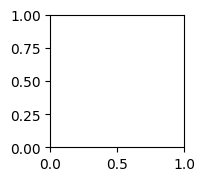

In [ ]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')
plot_imgs(data_path+'/organic')

<a id="gen"></a>
       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740);background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px;padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 3 | Generate Data</p>

In [ ]:
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

In [ ]:
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

<a id="tt"></a>
       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740);background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px;padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 4 | Split Train & Test Files</p>

In [ ]:
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2093 images belonging to 7 classes.


In [ ]:
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 367 images belonging to 7 classes.



       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740);background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px;padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 5 | Building Convolutional Neural Network Architecture</p>

In [ ]:
model = Sequential([
    ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    MaxPool2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.4),
    MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

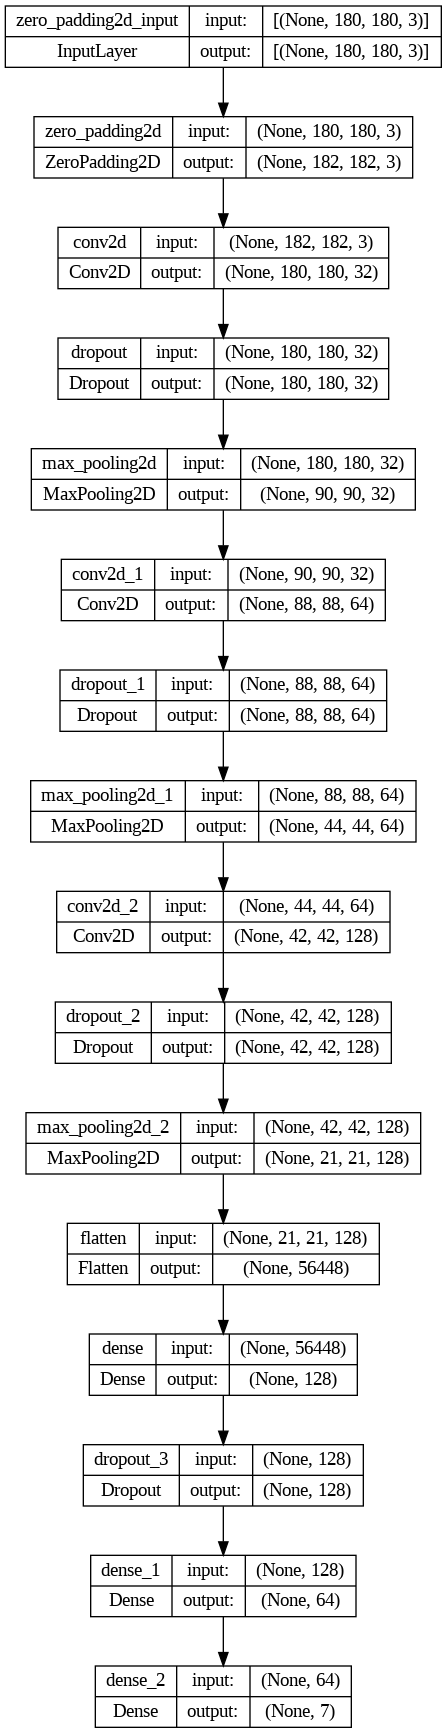

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

<a id="compiler"></a>
       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740);background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px;padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 6 | Compile Model</p>

In [ ]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [ ]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

📄 [Back to Tabel of Contents](#tc)
<a id="train"></a>
       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740);background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px;padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 7 | Train Model</p>

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/500
70/70 [==============================] - ETA: 0s - loss: 0.9184 - categorical_accuracy: 0.6909 

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/waste-type/glass/glass/glass_198.jpg'
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/waste-type/glass/glass/glass_198.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/waste-type/glass/glass/glass_198.jpg'
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/waste-type/glass/glass/glass_198.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_2223]

<a id="evaluate"></a>
       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740);background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px;padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 8 | Model Evaluation</p>

In [ ]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

In [ ]:
accuracy = history.history['categorical_accuracy']

val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

<a id="use"></a>
       
# <p style="background-image: url(https://img.freepik.com/premium-vector/plastic-waste-ocean-pollution-seamless-pattern-vector-illustration-eco-problem-water-pollution-trash_98734-287.jpg?w=740);background-size: 40% auto;font-family:camtasia;font-size:150%;font-weight: bold;color: #ffffff;text-align:center;text-shadow: 0px 0px 10px #000000;margin: 0 auto;border-radius:10px;padding:7px;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">Step 9 |  Using Model</p>

In [ ]:
classes = train_data.class_indices
classes

In [ ]:
img = utils.load_img(
    '/kaggle/input/trash-type-detection/trash_images/cardboard/cardboard_011.jpg',
    grayscale=False,
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [ ]:
img = utils.img_to_array(img)
img = img / 255.0

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

#### Step 10 | Saving Model

In [ ]:
from google.colab import files
files.download('trash.h5')